#### This is the First Task of Machine Learning internship at CODSOFT.Where we have to create a ML model that can easily identify and predict the genre of a movie based on the plot summary information.And this model is done usinf the techniques like TF-IDF along with the help of Naive Bayes and Support vector mechanisms.

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping

# Step 1: Data Preprocessing
### Here we will Load and preprocess the data in the form of a dataset which will be given as the source copy of entire genres list.


In [31]:
training_path='/kaggle/input/genre-classification-dataset-imdb/Genre Classification Dataset/train_data.txt'
training_data=pd.read_csv( training_path , sep=':::',engine='python',names=['Movie_Title','Genre_Type','Description_of_movie'])
training_data.head(10)

,Movie_Title,Genre_Type,Description_of_movie
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...
6,Quality Control (2011),documentary,Quality Control consists of a series of 16mm ...
7,"""Pink Slip"" (2009)",comedy,In tough economic times Max and Joey have all...
8,One Step Away (1985),crime,Ron Petrie (Keanu Reeves) is a troubled teen ...
9,"""Desperate Hours"" (2016)",reality-tv,"A sudden calamitous event, causing great loss..."
10,Spirits (2014/I),horror,Four high school students embark on a terrify...


In [33]:
testing_path='/kaggle/input/genre-classification-dataset-imdb/Genre Classification Dataset/test_data.txt'
testing_data=pd.read_csv( testing_path , sep=':::',engine='python',names=['ID', 'Movie_Title','Description_of_Movie'])
testing_data.head(10)

,ID,Movie_Title,Description_of_Movie
0,1,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar..."
1,2,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch..."
2,3,Off the Beaten Track (2010),One year in the life of Albin and his family ...
3,4,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi..."
4,5,Er nu zhai (1955),Before he was known internationally as a mart...
5,6,Riddle Room (2016),Emily Burns is being held captive in a room w...
6,7,L'amica (1969),The beautiful but neglected wife of a brillia...
7,8,Ina Mina Dika (1989),Vasu Inamdar (Ina) suffers from a disorder wh...
8,9,Equinox Special: Britain's Tornados (2005),An insight into the tornados that hit Kensal ...
9,10,Press (2011),Press is a story of young people overwhelmed ...


In [34]:
training_data.describe()

,Movie_Title,Genre_Type,Description_of_movie
count,54214,54214,54214
unique,54214,27,54086
top,Oscar et la dame rose (2009),drama,Grammy - music award of the American academy ...
freq,1,13613,12


In [35]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54214 entries, 1 to 54214
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Movie_Title           54214 non-null  object
 1   Genre_Type            54214 non-null  object
 2   Description_of_movie  54214 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


In [36]:
training_data.isnull().sum()

Movie_Title             0
Genre_Type              0
Description_of_movie    0
dtype: int64

# Step 2: Data visualizations

Text(0.5, 1.0, 'Data Analysis of Genres')

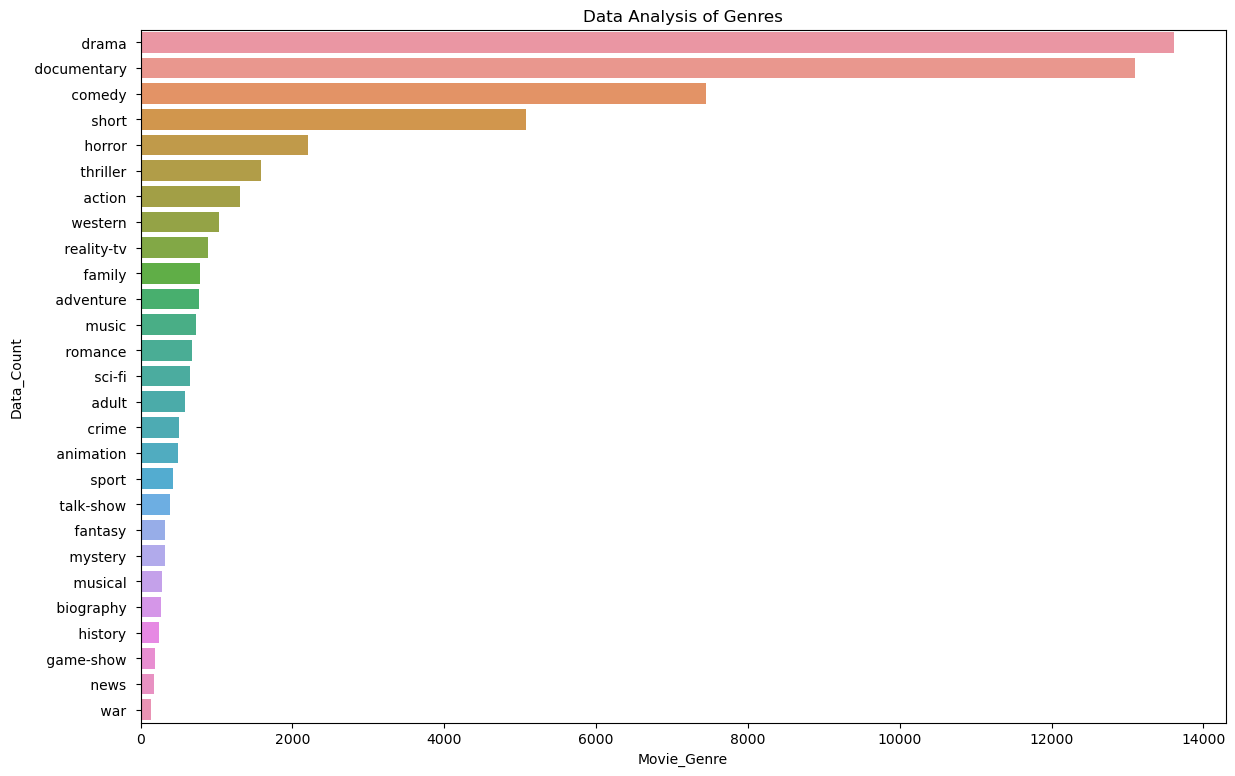

In [38]:
plt.figure(figsize=(14,9))
counts = training_data.Genre_Type.value_counts()
sns.barplot(x=counts, y=counts.index, orient=None)  
plt.xlabel('Movie_Genre')
plt.ylabel('Data_Count')
plt.title('Data Analysis of Genres')

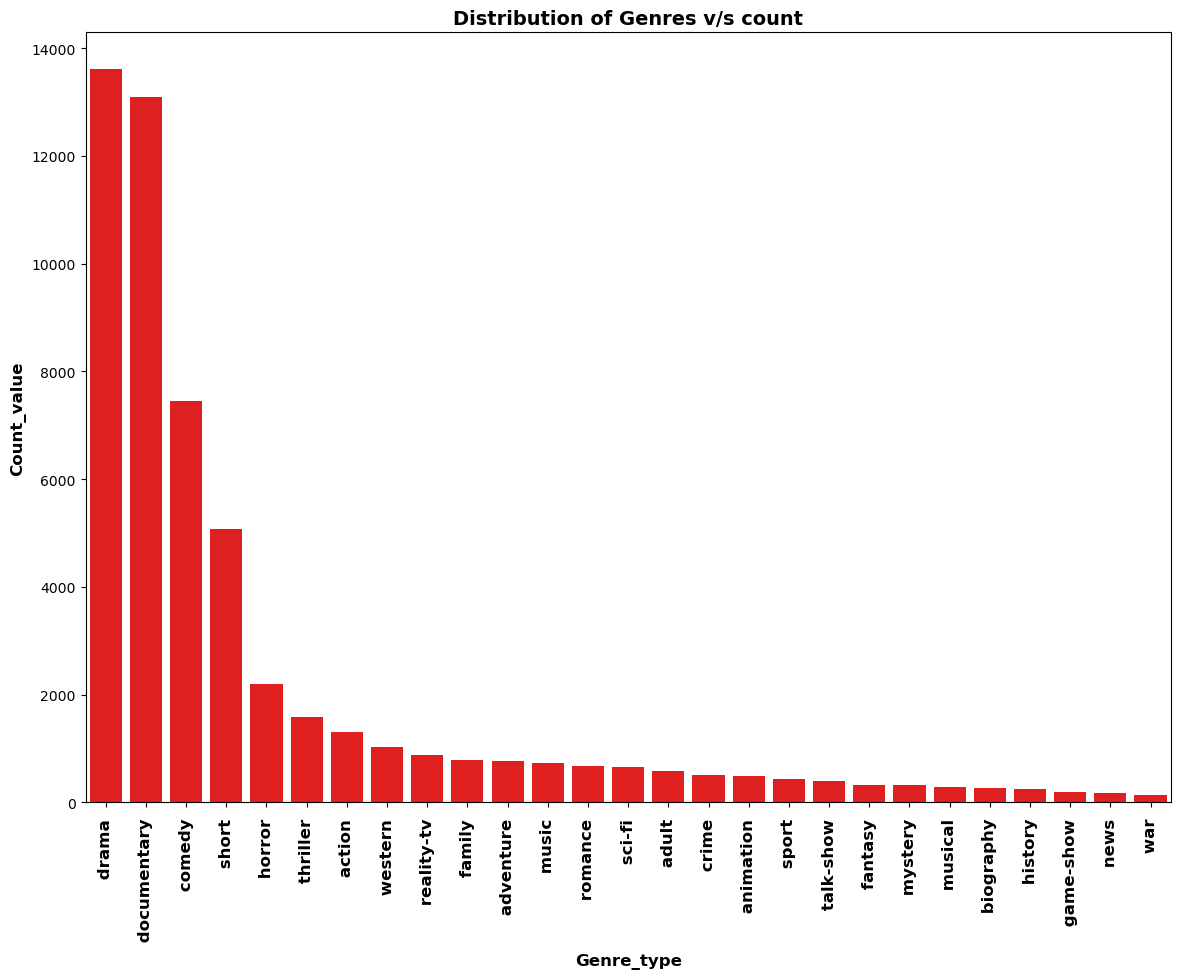

In [39]:
plt.figure(figsize=(14,10))
counts = training_data.Genre_Type.value_counts()
sns.barplot(x=counts.index, y=counts, color='red')
plt.xlabel('Genre_type' ,fontsize=12, fontweight='bold')
plt.ylabel('Count_value', fontsize=12, fontweight='bold')
plt.title('Distribution of Genres v/s count', fontsize=14, fontweight='bold')
plt.xticks(rotation=90, fontsize=12, fontweight='bold');

In [41]:
training_data['length']=training_data['Description_of_movie'].apply(len)
training_data.head(10)

,Movie_Title,Genre_Type,Description_of_movie,length
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...,546
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...,184
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...,650
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...,1082
5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...,625
6,Quality Control (2011),documentary,Quality Control consists of a series of 16mm ...,1609
7,"""Pink Slip"" (2009)",comedy,In tough economic times Max and Joey have all...,345
8,One Step Away (1985),crime,Ron Petrie (Keanu Reeves) is a troubled teen ...,332
9,"""Desperate Hours"" (2016)",reality-tv,"A sudden calamitous event, causing great loss...",456
10,Spirits (2014/I),horror,Four high school students embark on a terrify...,426


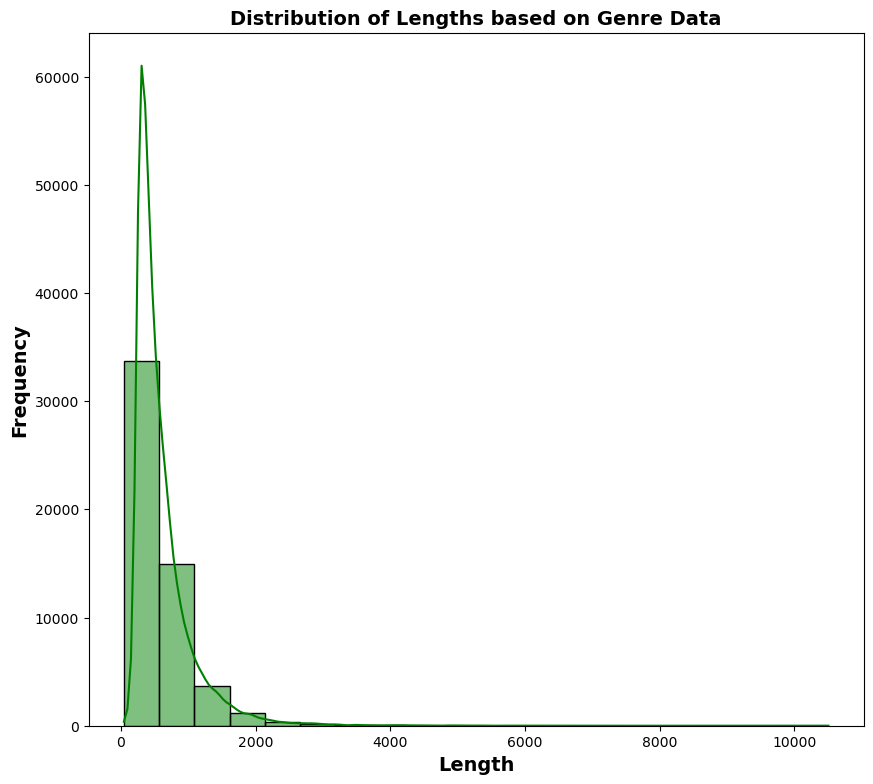

In [42]:
plt.figure(figsize=(10, 9))

sns.histplot(data=training_data, x='length', bins=20, kde=True, color='green')

plt.xlabel('Length', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')
plt.title('Distribution of Lengths based on Genre Data', fontsize=14, fontweight='bold')

plt.show()

# Step 3: Data cleaning and preprocessing


In [43]:
stemmer = LancasterStemmer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
   
    text = text.lower()                                  # lower-case all characters
    text = re.sub('-',' ',text.lower())   # replace `word-word` as `word word`
    text = re.sub(f'[{string.digits}]',' ',text)  # remove digits
    text = ' '.join([stemmer.stem(word) for word in text.split() if word not in stop_words])  # remove stopwords and stem other words
    text =  re.sub(r'@\S+', '',text)                     # remove twitter handles
    text =  re.sub(r'http\S+', '',text)                  # remove urls
    text =  re.sub(r'pic.\S+', '',text) 
    text =  re.sub(r"[^a-zA-Z+']", ' ',text)             # only keeps characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text+' ')      # keep words with length>1 only
    text = "".join([i for i in text if i not in string.punctuation])
    words = nltk.tokenize.word_tokenize(text,language="english", preserve_line=True)
    stopwords = nltk.corpus.stopwords.words('english')   # remove stopwords
    text = " ".join([i for i in words if i not in stopwords and len(i)>2])
    text= re.sub("\s[\s]+", " ",text).strip()            # remove repeated/leading/trailing spaces
    return re.sub(f'[{re.escape(string.punctuation)}]','',text) # remove punctuations


# Test your cleaning function
input_text = "Certainly you get a dramatic boost from hello bye the the hi -iv iem-k q934*2yee !*3 2e38"
print(f'Original text: {input_text}')
print(f'Cleaned text: {clean_text(input_text)}')

Original text: Certainly you get a dramatic boost from hello bye the the hi -iv iem-k q934*2yee !*3 2e38
Cleaned text: certain get dram boost hello bye iem


In [47]:
training_data['Text_cleaning'] = training_data.Description_of_movie.apply(clean_text)
testing_data['Text_cleaning'] = testing_data.Description_of_Movie.apply(clean_text)

training_data.head(10)


,Movie_Title,Genre_Type,Description_of_movie,length,Text_cleaning
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...,546,list convers doct parents year old osc learn n...
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...,184,broth sist past incestu rel cur murd relations...
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...,650,bus empty stud field trip muse nat history lit...
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...,1082,help unemploy fath mak end meet edi twin sist ...
5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...,625,films titl ref recov body ground zero also sta...
6,Quality Control (2011),documentary,Quality Control consists of a series of 16mm ...,1609,qual control consist sery singl tak shot film ...
7,"""Pink Slip"" (2009)",comedy,In tough economic times Max and Joey have all...,345,tough econom tim max joey run idea discov seny...
8,One Step Away (1985),crime,Ron Petrie (Keanu Reeves) is a troubled teen ...,332,ron petry keanu reeves troubl teen whos lif ha...
9,"""Desperate Hours"" (2016)",reality-tv,"A sudden calamitous event, causing great loss...",456,sud calamit event caus gre loss life damage ha...
10,Spirits (2014/I),horror,Four high school students embark on a terrify...,426,four high school stud embark terr journey shad...


In [48]:
training_data['length_Text_cleaning']=training_data['Text_cleaning'].apply(len)
training_data.head(10)

,Movie_Title,Genre_Type,Description_of_movie,length,Text_cleaning,length_Text_cleaning
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...,546,list convers doct parents year old osc learn n...,324
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...,184,broth sist past incestu rel cur murd relations...,83
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...,650,bus empty stud field trip muse nat history lit...,325
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...,1082,help unemploy fath mak end meet edi twin sist ...,616
5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...,625,films titl ref recov body ground zero also sta...,282
6,Quality Control (2011),documentary,Quality Control consists of a series of 16mm ...,1609,qual control consist sery singl tak shot film ...,998
7,"""Pink Slip"" (2009)",comedy,In tough economic times Max and Joey have all...,345,tough econom tim max joey run idea discov seny...,165
8,One Step Away (1985),crime,Ron Petrie (Keanu Reeves) is a troubled teen ...,332,ron petry keanu reeves troubl teen whos lif ha...,200
9,"""Desperate Hours"" (2016)",reality-tv,"A sudden calamitous event, causing great loss...",456,sud calamit event caus gre loss life damage ha...,227
10,Spirits (2014/I),horror,Four high school students embark on a terrify...,426,four high school stud embark terr journey shad...,266


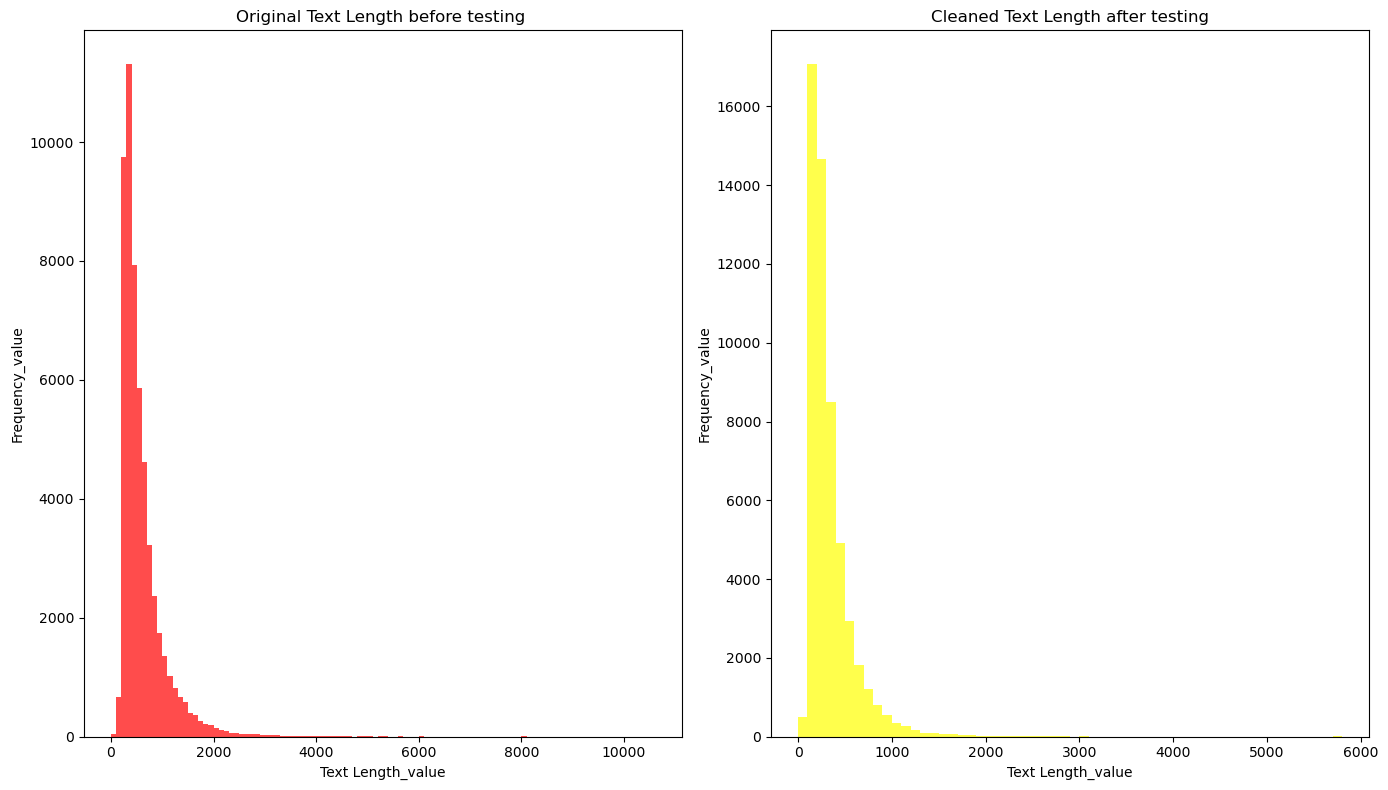

In [49]:
# Create histograms for text length before and after cleaning
plt.figure(figsize=(14, 8))

# Original text length distribution
plt.subplot(1, 2, 1)
original_lengths = training_data['Description_of_movie'].apply(len)
plt.hist(original_lengths, bins=range(0, max(original_lengths) + 100, 100), color='red', alpha=0.7)
plt.title('Original Text Length before testing ')
plt.xlabel('Text Length_value')
plt.ylabel('Frequency_value')

# Cleaned text length distribution
plt.subplot(1, 2, 2)
cleaned_lengths = training_data['Text_cleaning'].apply(len)
plt.hist(cleaned_lengths, bins=range(0, max(cleaned_lengths) + 100, 100), color='yellow', alpha=0.7)
plt.title('Cleaned Text Length after testing')
plt.xlabel('Text Length_value')
plt.ylabel('Frequency_value')

plt.tight_layout()
plt.show()

In [50]:
(training_data['length_Text_cleaning']>2000).value_counts()

False    54131
True        83
Name: length_Text_cleaning, dtype: int64

In [51]:
#Remove extremely long descriptions: outliers
print('Dataframe size (before removal) i.e intial stage of training : ',len(training_data))
filt=training_data['length_Text_cleaning']>2000
training_data.drop(training_data[filt].index,axis=0,inplace=True)     # filter rows having cleaned description length > 2000
print('Dataframe size (after removal) i.e final stage of training: ',len(training_data))
print(f'Removed rows from the given dataset: {filt.sum()}')

Dataframe size (before removal) i.e intial stage of training :  54214
Dataframe size (after removal) i.e final stage of training:  54131
Removed rows from the given dataset: 83


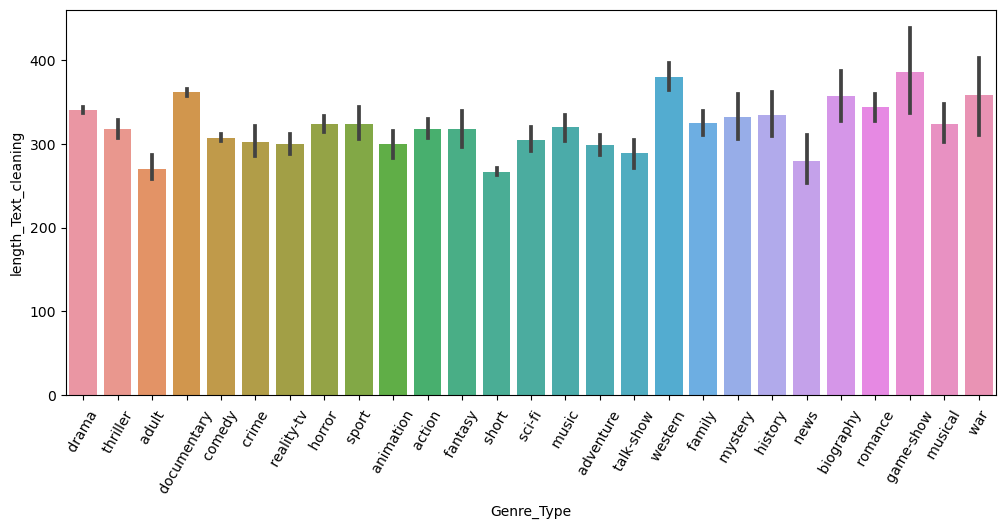

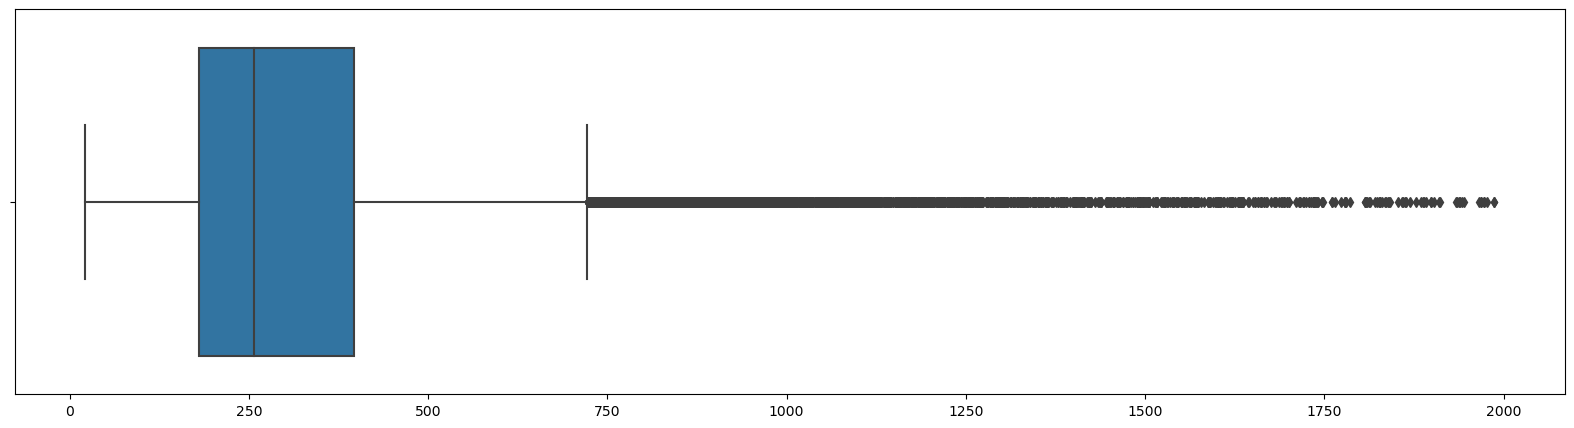

In [55]:
plt.figure(figsize=(12,5))
sns.barplot(x='Genre_Type',y='length_Text_cleaning',data=training_data)  # from 600ish to 350ish -> significant reduction in length
plt.xticks(rotation=60)
plt.show()
plt.figure(figsize=(20,5))
sns.boxplot(x=training_data['length_Text_cleaning'].values,hue='Genre_Type',data=training_data)
plt.show()

# Step 4: Text tokenization and vectorization



In [56]:
num_words = 50000
max_len = 250
tokenizer = Tokenizer(num_words=num_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(training_data['Text_cleaning'].values)

In [58]:
testing_path='/kaggle/input/genre-classification-dataset-imdb/Genre Classification Dataset/test_data_solution.txt'
testing_data_solution=pd.read_csv( testing_path , sep=':::',engine='python',names=['ID','Movie_Title','Genre_Type','Description_of_movie'])
testing_data_solution.head()

,ID,Movie_Title,Genre_Type,Description_of_movie
0,1,Edgar's Lunch (1998),thriller,"L.R. Brane loves his life - his car, his apar..."
1,2,La guerra de papá (1977),comedy,"Spain, March 1964: Quico is a very naughty ch..."
2,3,Off the Beaten Track (2010),documentary,One year in the life of Albin and his family ...
3,4,Meu Amigo Hindu (2015),drama,"His father has died, he hasn't spoken with hi..."
4,5,Er nu zhai (1955),drama,Before he was known internationally as a mart...


# Step 5:  Text Vectorization (TF-IDF)

In [59]:
X = tokenizer.texts_to_sequences(training_data['Text_cleaning'].values)
X = pad_sequences(X, maxlen=max_len)
y = pd.get_dummies(training_data['Genre_Type']).values

X_test = tokenizer.texts_to_sequences(testing_data['Text_cleaning'].values)
X_test = pad_sequences(X_test, maxlen=max_len)
y_test = pd.get_dummies(testing_data_solution['Genre_Type']).values

# Step 6: Build the LSTM model


In [60]:
EMBEDDING_DIM = 100
model = Sequential()
model.add(Embedding(num_words, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.1, recurrent_dropout=0.2))
model.add(Dense(27, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])  

# Step 7: Train the model


In [61]:
my_callbacks  = [EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=2,
                              mode='auto')]
history = model.fit(X, y, epochs=6, batch_size=32,validation_data=(X_test,y_test), callbacks=my_callbacks)


Epoch 1/6
1692/1692 [==============================] - 837s 493ms/step - loss: 1.9653 - accuracy: 0.4322 - val_loss: 1.6954 - val_accuracy: 0.5030
Epoch 2/6
  39/1692 [..............................] - ETA: 12:02 - loss: 1.5372 - accuracy: 0.5633

KeyboardInterrupt: 

# Step 8: Plotting Accuracy & Loss

NameError: name 'history' is not defined

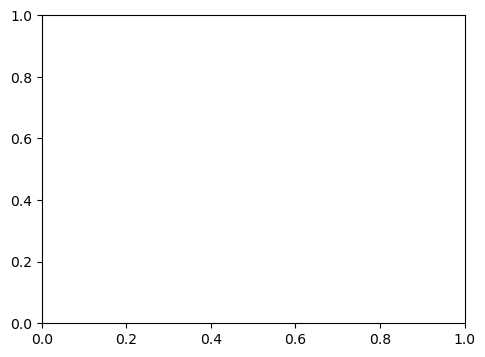

In [62]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.tight_layout()
plt.show()


In [63]:
# Task Done